# Random_Forest

/tmp/ipykernel_36/2524258074.py:24: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH).drop_duplicates()


                                     sql_query injection_type  \
0   SELECT * FROM users WHERE id = 1 OR 1=1 --  boolean-based   
1    SELECT * FROM users WHERE id = 1 OR 1=1 #  boolean-based   
2      SELECT * FROM users WHERE id = 1 OR 1=1  boolean-based   
3  SELECT * FROM users WHERE id != 1 OR 1=1 --  boolean-based   
4   SELECT * FROM users WHERE id != 1 OR 1=1 #  boolean-based   

  vulnerability_status sql_command target_table selected_columns  \
0                  Yes      SELECT        users                *   
1                  Yes      SELECT        users                *   
2                  Yes      SELECT        users                *   
3                  Yes      SELECT        users                *   
4                  Yes      SELECT        users                *   

  comparison_operator logical_operator sql_comment_syntax  \
0                   =              NaN                 --   
1                   =              NaN                  #   
2                

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Training complete

Accuracy: 0.7843


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


AUC-ROC: 0.9700
Mean Average Precision (mAP): 0.8465

Classification Report:
                    precision    recall  f1-score   support

       Error-Based       0.75      0.12      0.20       700
         None_Type       0.96      0.99      0.98       700
        Time-Based       0.77      0.98      0.86       700
       Union-Based       0.57      0.95      0.71       700
     boolean-based       0.91      0.93      0.92       700
        meta_based       0.81      0.70      0.75       700
stackqueries_based       0.83      0.82      0.82       700

          accuracy                           0.78      4900
         macro avg       0.80      0.78      0.75      4900
      weighted avg       0.80      0.78      0.75      4900



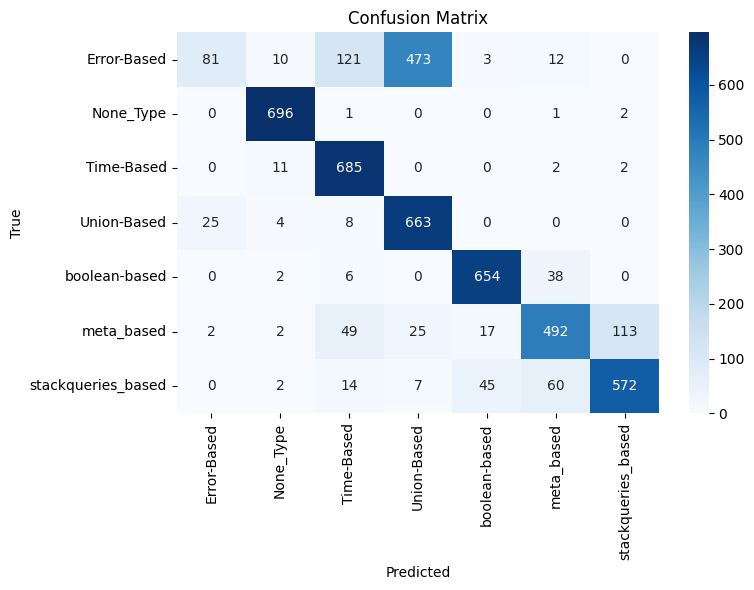

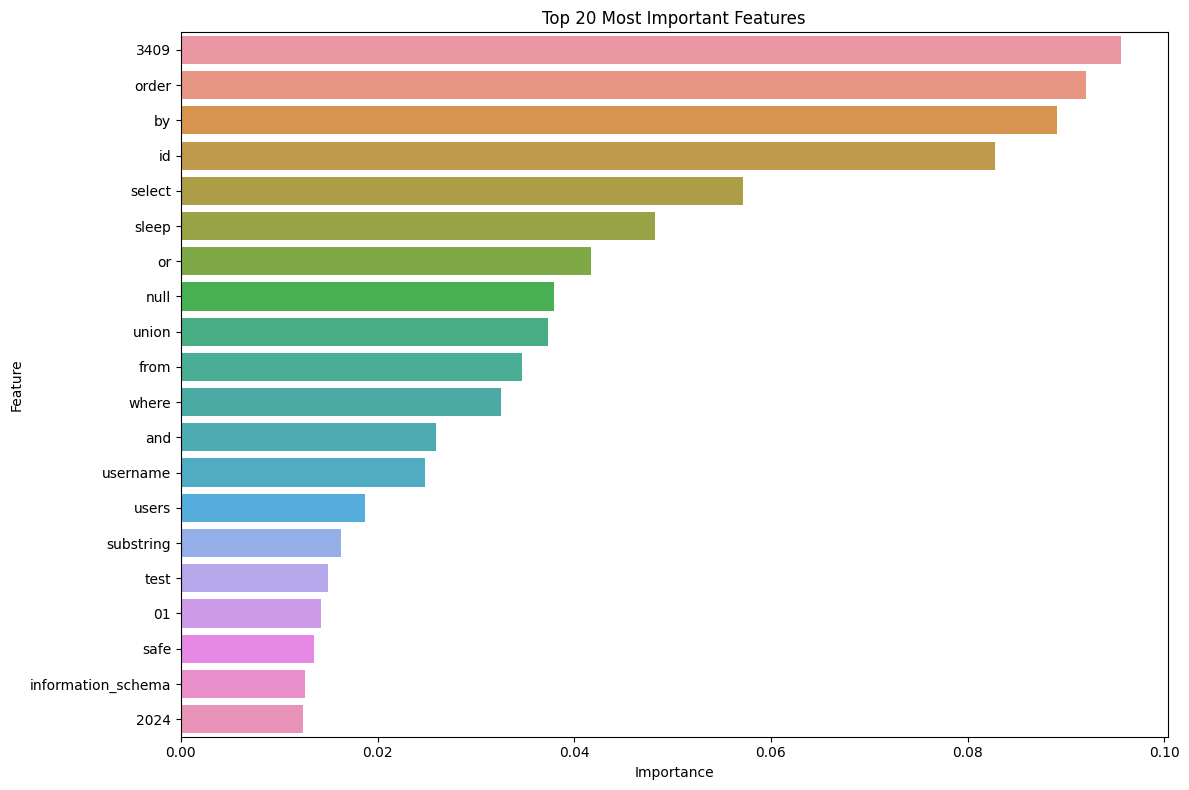

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Config
# -------------------------------
SEED = 42
TRAIN_PER_CLASS = 7300
VAL_PER_CLASS = 2000
TEST_PER_CLASS = 700
TOTAL_PER_CLASS = TRAIN_PER_CLASS + VAL_PER_CLASS + TEST_PER_CLASS 

DATA_PATH = '/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv'

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
data = pd.read_csv(DATA_PATH).drop_duplicates()
print(data.head())
print("Column names:", data.columns.tolist())

# Ensure required columns exist
required_cols = {'sql_query', 'injection_type'}
missing = required_cols - set(data.columns)
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

# Use existing injection_type as the label
data['Combined Label'] = data['injection_type']

# Stable, explicit class list
classes = sorted(data['Combined Label'].dropna().unique().tolist())
print(f"Detected {len(classes)} classes: {classes}")

# -------------------------------
# Build exact per-class splits with shuffling
# -------------------------------
train_parts, val_parts, test_parts = [], [], []
skipped_classes = []

for label in classes:
    class_df = data[data['Combined Label'] == label].copy()

    if len(class_df) == 0:
        print(f"Skipping class '{label}' due to 0 samples.")
        skipped_classes.append(label)
        continue

    # Shuffle class data
    class_df = class_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Sample exactly TOTAL_PER_CLASS per class (with replacement if needed)
    replace_flag = len(class_df) < TOTAL_PER_CLASS
    class_df_10k = class_df.sample(
        n=TOTAL_PER_CLASS, replace=replace_flag, random_state=SEED
    ).reset_index(drop=True)

    # Deterministic split per class
    train_cls = class_df_10k.iloc[:TRAIN_PER_CLASS].copy()
    val_cls = class_df_10k.iloc[TRAIN_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS].copy()
    test_cls = class_df_10k.iloc[TRAIN_PER_CLASS + VAL_PER_CLASS:].copy()

    # Collect
    train_parts.append(train_cls)
    val_parts.append(val_cls)
    test_parts.append(test_cls)

# Concatenate and shuffle each split
if not train_parts or not val_parts or not test_parts:
    raise ValueError("No data collected for one or more splits. Check class availability.")

train_df = pd.concat(train_parts, axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)
val_df = pd.concat(val_parts, axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)
test_df = pd.concat(test_parts, axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)

# -------------------------------
# Verify exact per-class counts
# -------------------------------
def print_split_counts(df, name):
    counts = df['Combined Label'].value_counts().sort_index()
    print(f"\n{name} per-class counts:")
    print(counts)
    # Optional: assert exact counts for classes not skipped
    for cls in classes:
        if cls in skipped_classes:
            continue
        expected = TRAIN_PER_CLASS if name == "Train" else VAL_PER_CLASS if name == "Validation" else TEST_PER_CLASS
        actual = counts.get(cls, 0)
        if actual != expected:
            print(f"WARNING: Class '{cls}' in {name} has {actual}, expected {expected}.")

print_split_counts(train_df, "Train")
print_split_counts(val_df, "Validation")
print_split_counts(test_df, "Test")

# -------------------------------
# Label mapping (stable across splits)
# -------------------------------
# Use 'classes' order for a consistent mapping
label_mapping = {label: idx for idx, label in enumerate(classes)}
inverse_mapping = {v: k for k, v in label_mapping.items()}

# Map labels to integers
train_df['label'] = train_df['Combined Label'].map(label_mapping)
val_df['label'] = val_df['Combined Label'].map(label_mapping)
test_df['label'] = test_df['Combined Label'].map(label_mapping)

# -------------------------------
# Feature Extraction using TF-IDF (fit on Train only)
# -------------------------------
tfidf = TfidfVectorizer(max_features=5000)

X_train = tfidf.fit_transform(train_df['sql_query'])
y_train = train_df['label'].values

X_val = tfidf.transform(val_df['sql_query'])
y_val = val_df['label'].values

X_test = tfidf.transform(test_df['sql_query'])
y_test = test_df['label'].values

print(f"\nShapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# -------------------------------
# Model Training with Random Forest
# -------------------------------
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete")

# -------------------------------
# Predictions and Evaluation
# -------------------------------
predictions = rf_model.predict(X_test)
predicted_probs = rf_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

n_classes = len(classes)
if n_classes > 2:
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    auc_roc = roc_auc_score(y_test_bin, predicted_probs, multi_class="ovr")
    mAP = average_precision_score(y_test_bin, predicted_probs, average="macro")
else:
    auc_roc = roc_auc_score(y_test, predicted_probs[:, 1])
    mAP = average_precision_score(y_test, predicted_probs[:, 1])

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Classification report with consistent label order
ordered_labels = list(range(n_classes))
target_names = [inverse_mapping[i] for i in ordered_labels]
print("\nClassification Report:")
print(classification_report(y_test, predictions, labels=ordered_labels, target_names=target_names, zero_division=0))

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, predictions, labels=ordered_labels)
plt.figure(figsize=(max(8, n_classes), max(6, n_classes * 0.6)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# -------------------------------
# Feature Importances
# -------------------------------
if hasattr(rf_model, 'feature_importances_'):
    feature_importances = rf_model.feature_importances_
    feature_names = tfidf.get_feature_names_out()

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}) \
        .sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

# 

# Naive Bayes

/tmp/ipykernel_36/2210196221.py:35: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH).drop_duplicates()


Head:
                                     sql_query injection_type  \
0   SELECT * FROM users WHERE id = 1 OR 1=1 --  boolean-based   
1    SELECT * FROM users WHERE id = 1 OR 1=1 #  boolean-based   
2      SELECT * FROM users WHERE id = 1 OR 1=1  boolean-based   
3  SELECT * FROM users WHERE id != 1 OR 1=1 --  boolean-based   
4   SELECT * FROM users WHERE id != 1 OR 1=1 #  boolean-based   

  vulnerability_status sql_command target_table selected_columns  \
0                  Yes      SELECT        users                *   
1                  Yes      SELECT        users                *   
2                  Yes      SELECT        users                *   
3                  Yes      SELECT        users                *   
4                  Yes      SELECT        users                *   

  comparison_operator logical_operator sql_comment_syntax  \
0                   =              NaN                 --   
1                   =              NaN                  #   
2          

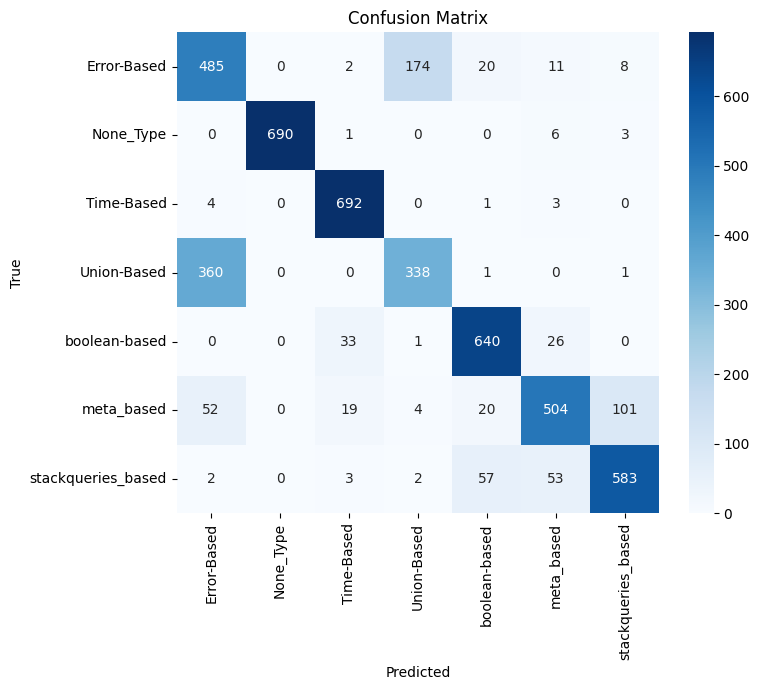

/tmp/ipykernel_36/2210196221.py:206: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_36/2210196221.py:209: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


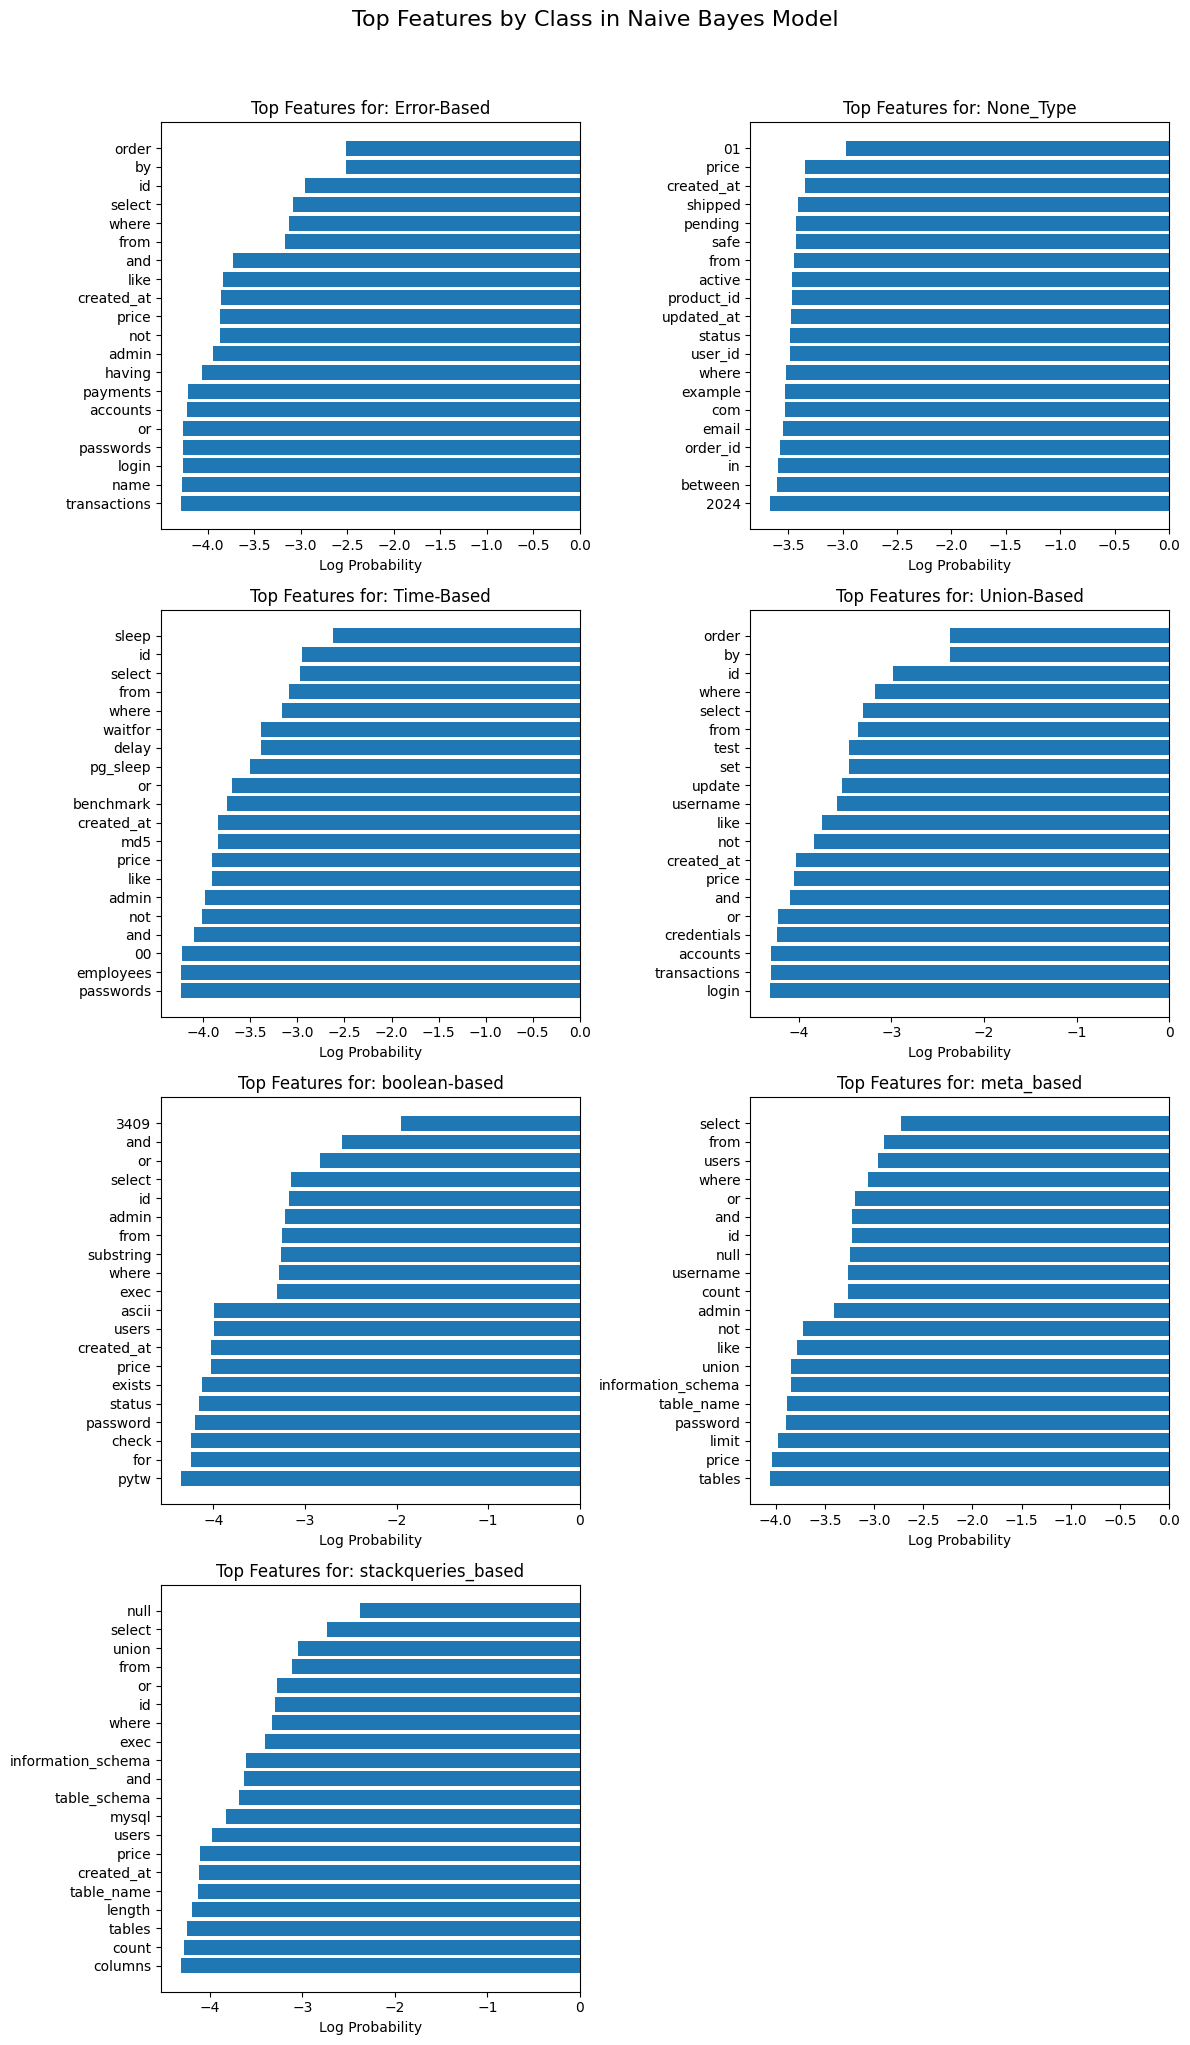

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Config
# -------------------------------
SEED = 42
TRAIN_PER_CLASS = 7300
VAL_PER_CLASS = 2000
TEST_PER_CLASS = 700
TOTAL_PER_CLASS = TRAIN_PER_CLASS + VAL_PER_CLASS + TEST_PER_CLASS  # 10,000

DATA_PATH = "/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv"
TEXT_COL = "sql_query"
LABEL_COL = "injection_type"

# -------------------------------
# Data Loading and Basic Cleaning
# -------------------------------
data = pd.read_csv(DATA_PATH).drop_duplicates()
# Basic sanity: drop rows with missing text or label
data = data.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)

print("Head:")
print(data.head())
print("Columns:", data.columns.tolist())
print(f"Rows after dedup/clean: {len(data)}")

# Global shuffle for reproducibility
data = data.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Use existing label column
data["Combined Label"] = data[LABEL_COL]
labels = sorted(data["Combined Label"].dropna().unique().tolist())
print(f"Found {len(labels)} classes.")

# -------------------------------
# Exact per-class split with shuffle
# - Exactly 7300 train, 2000 val, 700 test per class
# - If a class has < 10,000 rows, oversample with replacement
# -------------------------------
train_parts = []
val_parts = []
test_parts = []

for lbl in labels:
    class_df = data[data["Combined Label"] == lbl]

    if len(class_df) == 0:
        print(f"Skipping class '{lbl}' (0 samples).")
        continue

    need_replace = len(class_df) < TOTAL_PER_CLASS

    # Oversample/undersample to exactly TOTAL_PER_CLASS per class
    class_bal = class_df.sample(
        n=TOTAL_PER_CLASS,
        replace=need_replace,
        random_state=SEED
    ).reset_index(drop=True)

    # Shuffle within class to randomize rows before slicing
    class_bal = class_bal.sample(frac=1, random_state=SEED + 1).reset_index(drop=True)

    # Slice exact counts
    train_slice = class_bal.iloc[:TRAIN_PER_CLASS].copy()
    val_slice = class_bal.iloc[TRAIN_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS].copy()
    test_slice = class_bal.iloc[TRAIN_PER_CLASS + VAL_PER_CLASS:].copy()  # remaining TEST_PER_CLASS

    # Accumulate
    train_parts.append(train_slice)
    val_parts.append(val_slice)
    test_parts.append(test_slice)

# Concatenate splits across classes
train_df = pd.concat(train_parts, axis=0).sample(frac=1, random_state=SEED + 2).reset_index(drop=True)
val_df = pd.concat(val_parts, axis=0).sample(frac=1, random_state=SEED + 3).reset_index(drop=True)
test_df = pd.concat(test_parts, axis=0).sample(frac=1, random_state=SEED + 4).reset_index(drop=True)

# Sanity checks: per-class counts
print("\nPer-class counts (train):")
print(train_df["Combined Label"].value_counts())
print("\nPer-class counts (val):")
print(val_df["Combined Label"].value_counts())
print("\nPer-class counts (test):")
print(test_df["Combined Label"].value_counts())

# -------------------------------
# Label encoding (stable, sorted by label name)
# -------------------------------
label_to_idx = {lbl: i for i, lbl in enumerate(labels)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

train_df["label"] = train_df["Combined Label"].map(label_to_idx)
val_df["label"] = val_df["Combined Label"].map(label_to_idx)
test_df["label"] = test_df["Combined Label"].map(label_to_idx)

# -------------------------------
# TF-IDF (fit on train ONLY to avoid leakage)
# -------------------------------
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df[TEXT_COL])
X_val = tfidf.transform(val_df[TEXT_COL])
X_test = tfidf.transform(test_df[TEXT_COL])

y_train = train_df["label"].to_numpy()
y_val = val_df["label"].to_numpy()
y_test = test_df["label"].to_numpy()

print(f"\nTF-IDF shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

# -------------------------------
# Naive Bayes Training
# -------------------------------
nb_model = MultinomialNB(alpha=1.0)
print("\nTraining Naive Bayes...")
nb_model.fit(X_train, y_train)
print("Training complete.")

val_accuracy = nb_model.score(X_val, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

# -------------------------------
# Evaluation on Test
# -------------------------------
pred_labels = nb_model.predict(X_test)
predicted_probs = nb_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, pred_labels)
print(f"\nTest Accuracy: {accuracy:.4f}")

num_classes = len(labels)
if num_classes > 2:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    auc_roc = roc_auc_score(y_test_bin, predicted_probs, multi_class="ovr")
    mAP = average_precision_score(y_test_bin, predicted_probs, average="macro")
else:
    auc_roc = roc_auc_score(y_test, predicted_probs[:, 1])
    mAP = average_precision_score(y_test, predicted_probs[:, 1])

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Classification report with correct label order
target_names = [idx_to_label[i] for i in range(num_classes)]
print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=target_names))

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, pred_labels, labels=np.arange(num_classes))
plt.figure(figsize=(max(8, num_classes), max(6, num_classes)))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# -------------------------------
# Naive Bayes "Feature Importance" (per-class top features by log prob)
# -------------------------------
feature_names = tfidf.get_feature_names_out()

if hasattr(nb_model, "feature_log_prob_"):
    n_cols = 2
    n_rows = int(np.ceil(num_classes / n_cols))
    plt.figure(figsize=(12, 5 * n_rows))

    for i in range(num_classes):
        log_probs = nb_model.feature_log_prob_[i]
        top_indices = np.argsort(log_probs)[-20:]
        top_features = [feature_names[j] for j in top_indices]
        top_importances = log_probs[top_indices]

        ax = plt.subplot(n_rows, n_cols, i + 1)
        y_pos = np.arange(len(top_features))
        ax.barh(y_pos, top_importances, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Log Probability')
        ax.set_title(f"Top Features for: {idx_to_label[i]}")
        plt.tight_layout()

    plt.suptitle('Top Features by Class in Naive Bayes Model', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("feature_log_prob_ not available on the model; skipping feature importance plot.")

# SVC

/tmp/ipykernel_36/2848741689.py:34: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv').drop_duplicates()


                                     sql_query injection_type  \
0   SELECT * FROM users WHERE id = 1 OR 1=1 --  boolean-based   
1    SELECT * FROM users WHERE id = 1 OR 1=1 #  boolean-based   
2      SELECT * FROM users WHERE id = 1 OR 1=1  boolean-based   
3  SELECT * FROM users WHERE id != 1 OR 1=1 --  boolean-based   
4   SELECT * FROM users WHERE id != 1 OR 1=1 #  boolean-based   

  vulnerability_status sql_command target_table selected_columns  \
0                  Yes      SELECT        users                *   
1                  Yes      SELECT        users                *   
2                  Yes      SELECT        users                *   
3                  Yes      SELECT        users                *   
4                  Yes      SELECT        users                *   

  comparison_operator logical_operator sql_comment_syntax  \
0                   =              NaN                 --   
1                   =              NaN                  #   
2                

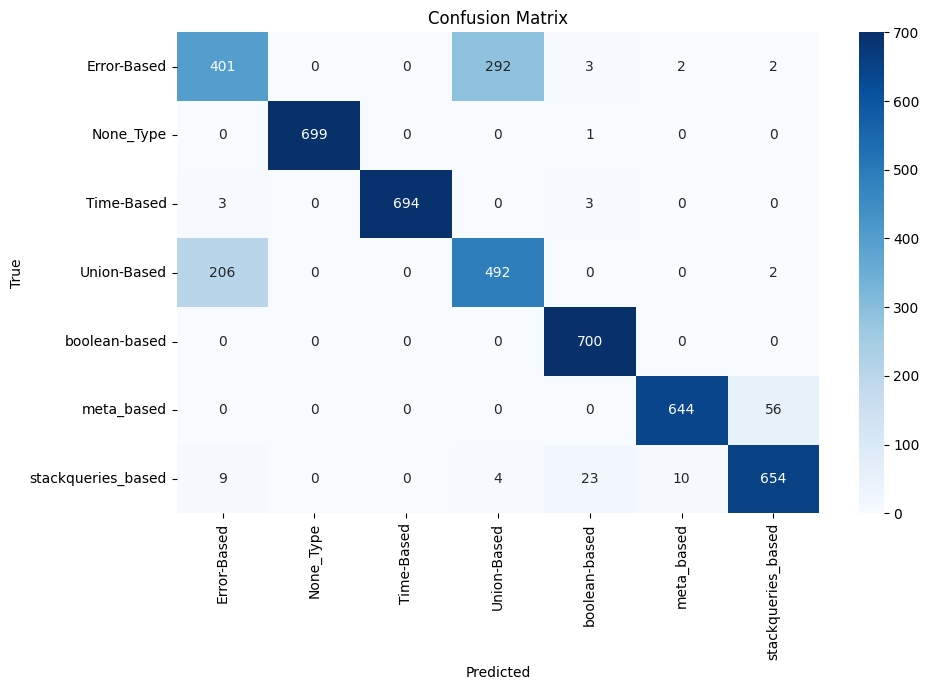

Number of support vectors: 19499
Number of support vectors per class: [6009  473 1028 5514 1602 2242 2631]


In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

# Desired exact counts per class
N_TRAIN_PER_CLASS = 7300
N_VAL_PER_CLASS = 2000
N_TEST_PER_CLASS = 700
TOTAL_PER_CLASS = N_TRAIN_PER_CLASS + N_VAL_PER_CLASS + N_TEST_PER_CLASS  # 10,000

def print_split_counts(split_df: pd.DataFrame, label_col: str, split_name: str):
    counts = split_df[label_col].value_counts().sort_index()
    print(f"\n{split_name} counts per class:")
    print(counts.to_string())

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------

# Load the dataset and remove duplicates
data = pd.read_csv('/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv').drop_duplicates()
print(data.head())
print("Column names:", data.columns.tolist())

# Required columns check
required_cols = {'sql_query', 'injection_type'}
missing = required_cols - set(data.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Shuffle the raw dataset for robustness
data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Combined label from injection_type
data['Combined Label'] = data['injection_type']

# Map string labels to numeric ids (stable, sorted by label for consistency)
unique_labels_sorted = sorted(data['Combined Label'].dropna().unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels_sorted)}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Add numeric label
data['label'] = data['Combined Label'].map(label_mapping)

# -------------------------------
# Balance data: exactly TOTAL_PER_CLASS per class
#   - If class has >= TOTAL_PER_CLASS, sample without replacement
#   - Else upsample with replacement to reach TOTAL_PER_CLASS
# -------------------------------
balanced_parts = []
for lbl, grp in data.groupby('label', sort=True):
    grp = grp.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)  # shuffle per class
    if len(grp) >= TOTAL_PER_CLASS:
        sampled = grp.sample(n=TOTAL_PER_CLASS, random_state=RANDOM_STATE, replace=False)
    else:
        sampled = grp.sample(n=TOTAL_PER_CLASS, random_state=RANDOM_STATE, replace=True)
    balanced_parts.append(sampled)

balanced_data = pd.concat(balanced_parts, axis=0).reset_index(drop=True)

# Verify balancing
print("\nBalanced class counts (should all be 10,000):")
print(balanced_data['label'].value_counts().sort_index().to_string())

# -------------------------------
# Exact per-class splits with shuffling
# -------------------------------
train_parts, val_parts, test_parts = [], [], []

for lbl, grp in balanced_data.groupby('label', sort=True):
    # Shuffle within class
    grp = grp.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    train_g = grp.iloc[:N_TRAIN_PER_CLASS]
    val_g   = grp.iloc[N_TRAIN_PER_CLASS:N_TRAIN_PER_CLASS + N_VAL_PER_CLASS]
    test_g  = grp.iloc[N_TRAIN_PER_CLASS + N_VAL_PER_CLASS:N_TRAIN_PER_CLASS + N_VAL_PER_CLASS + N_TEST_PER_CLASS]

    assert len(train_g) == N_TRAIN_PER_CLASS, f"Train count mismatch for label {lbl}"
    assert len(val_g)   == N_VAL_PER_CLASS,   f"Val count mismatch for label {lbl}"
    assert len(test_g)  == N_TEST_PER_CLASS,  f"Test count mismatch for label {lbl}"

    train_parts.append(train_g)
    val_parts.append(val_g)
    test_parts.append(test_g)

train_df = pd.concat(train_parts, axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
val_df   = pd.concat(val_parts, axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
test_df  = pd.concat(test_parts, axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print_split_counts(train_df, 'label', 'Training')
print_split_counts(val_df,   'label', 'Validation')
print_split_counts(test_df,  'label', 'Testing')

print(f"\nSizes -> Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# -------------------------------
# Feature Extraction using TF-IDF
#   Fit on TRAIN ONLY to avoid leakage, then transform val/test
# -------------------------------
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df['sql_query'])
X_val   = tfidf.transform(val_df['sql_query'])
X_test  = tfidf.transform(test_df['sql_query'])

y_train = train_df['label'].to_numpy()
y_val   = val_df['label'].to_numpy()
y_test  = test_df['label'].to_numpy()

# -------------------------------
# Model Training with SVC
# -------------------------------
svc_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,   # needed for ROC-AUC / mAP
    random_state=RANDOM_STATE,
    verbose=True
)

print("\nTraining SVC model...")
svc_model.fit(X_train, y_train)
print("Training complete")

# -------------------------------
# Predictions and Evaluation
# -------------------------------
predictions = svc_model.predict(X_test)
predicted_probs = svc_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

# Prepare classes order
label_ids_sorted = sorted(inv_label_mapping.keys())
class_names_sorted = [inv_label_mapping[i] for i in label_ids_sorted]

# Compute AUC-ROC and mAP
if len(label_ids_sorted) > 2:
    y_test_bin = label_binarize(y_test, classes=label_ids_sorted)
    auc_roc = roc_auc_score(y_test_bin, predicted_probs, multi_class="ovr", average="macro")
    mAP = average_precision_score(y_test_bin, predicted_probs, average="macro")
else:
    # Binary case
    pos_index = 1 if len(label_ids_sorted) == 2 else 0
    auc_roc = roc_auc_score(y_test, predicted_probs[:, pos_index])
    mAP = average_precision_score(y_test, predicted_probs[:, pos_index])

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=class_names_sorted, labels=label_ids_sorted))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions, labels=label_ids_sorted)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names_sorted,
    yticklabels=class_names_sorted
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# SVC support vectors info
print(f"Number of support vectors: {svc_model.support_vectors_.shape[0]}")
print(f"Number of support vectors per class: {svc_model.n_support_}")

# Decision function visualization (binary only)
if len(label_ids_sorted) == 2:
    decision_values = svc_model.decision_function(X_val)
    plt.figure(figsize=(10, 6))
    plt.hist(decision_values, bins=50)
    plt.title('SVM Decision Function Values (Validation)')
    plt.xlabel('Decision Value')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

# KNN

/tmp/ipykernel_36/3657931194.py:31: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv')


Balanced class counts (target = 10000 per class):
Combined Label
None_Type             10000
Error-Based           10000
meta_based            10000
stackqueries_based    10000
Time-Based            10000
Union-Based           10000
boolean-based         10000
Name: count, dtype: int64

Per-split class counts (should be exact):
Train:
 Combined Label
Error-Based           7300
None_Type             7300
Time-Based            7300
Union-Based           7300
boolean-based         7300
meta_based            7300
stackqueries_based    7300
Name: count, dtype: int64

Val:
 Combined Label
Error-Based           2000
None_Type             2000
Time-Based            2000
Union-Based           2000
boolean-based         2000
meta_based            2000
stackqueries_based    2000
Name: count, dtype: int64

Test:
 Combined Label
Error-Based           700
None_Type             700
Time-Based            700
Union-Based           700
boolean-based         700
meta_based            700
stackqueries_bas

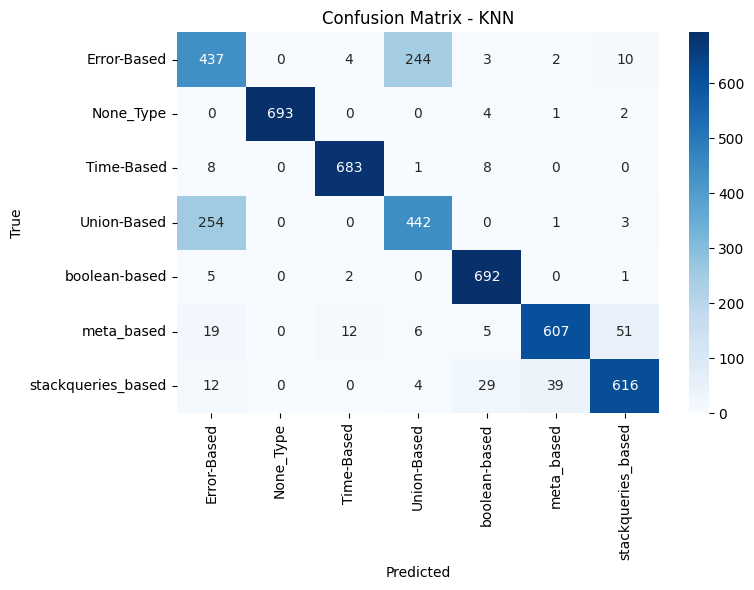

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, average_precision_score
)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Config
# -------------------------------
RANDOM_SEED_DATA = 42
RANDOM_SEED_SPLIT = 42
RANDOM_SEED_SHUFFLE = 123

TRAIN_PER_CLASS = 7300
VAL_PER_CLASS = 2000
TEST_PER_CLASS = 700
TOTAL_PER_CLASS = TRAIN_PER_CLASS + VAL_PER_CLASS + TEST_PER_CLASS  # 10000

TFIDF_MAX_FEATURES = 5000

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
data = (
    pd.read_csv('/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv')
    .drop_duplicates()
)

# Global shuffle for base data
data = data.sample(frac=1, random_state=RANDOM_SEED_DATA).reset_index(drop=True)

# Use 'injection_type' as Combined Label
data['Combined Label'] = data['injection_type']

# Balance to EXACTLY 10,000 per class (oversample with replacement if needed)
balanced_data = []
for label in data['Combined Label'].unique():
    class_data = data[data['Combined Label'] == label]
    if len(class_data) >= TOTAL_PER_CLASS:
        sampled = class_data.sample(n=TOTAL_PER_CLASS, random_state=RANDOM_SEED_DATA, replace=False)
    elif len(class_data) > 0:
        sampled = class_data.sample(n=TOTAL_PER_CLASS, random_state=RANDOM_SEED_DATA, replace=True)
    else:
        print(f"Skipping class {label} (0 samples).")
        continue
    balanced_data.append(sampled)

balanced_data = pd.concat(balanced_data, ignore_index=True)

print("Balanced class counts (target = 10000 per class):")
print(balanced_data['Combined Label'].value_counts())

# Label mapping (stable, sorted order)
classes = sorted(balanced_data['Combined Label'].unique())
label_mapping = {label: idx for idx, label in enumerate(classes)}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# -------------------------------
# Exact Per-Class Split (7300/2000/700)
# -------------------------------
train_parts, val_parts, test_parts = [], [], []

for cls in classes:
    cls_df = balanced_data[balanced_data['Combined Label'] == cls]
    # Shuffle within class before slicing
    cls_df = cls_df.sample(frac=1, random_state=RANDOM_SEED_SPLIT).reset_index(drop=True)

    train_slice = cls_df.iloc[:TRAIN_PER_CLASS]
    val_slice = cls_df.iloc[TRAIN_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS]
    test_slice = cls_df.iloc[TRAIN_PER_CLASS + VAL_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS + TEST_PER_CLASS]

    # Safety checks
    assert len(train_slice) == TRAIN_PER_CLASS, f"Train size mismatch for class {cls}"
    assert len(val_slice) == VAL_PER_CLASS, f"Val size mismatch for class {cls}"
    assert len(test_slice) == TEST_PER_CLASS, f"Test size mismatch for class {cls}"

    train_parts.append(train_slice)
    val_parts.append(val_slice)
    test_parts.append(test_slice)

train_df = pd.concat(train_parts, ignore_index=True).sample(frac=1, random_state=RANDOM_SEED_SHUFFLE).reset_index(drop=True)
val_df = pd.concat(val_parts, ignore_index=True).sample(frac=1, random_state=RANDOM_SEED_SHUFFLE).reset_index(drop=True)
test_df = pd.concat(test_parts, ignore_index=True).sample(frac=1, random_state=RANDOM_SEED_SHUFFLE).reset_index(drop=True)

print("\nPer-split class counts (should be exact):")
print("Train:\n", train_df['Combined Label'].value_counts().sort_index())
print("\nVal:\n", val_df['Combined Label'].value_counts().sort_index())
print("\nTest:\n", test_df['Combined Label'].value_counts().sort_index())

print(f"\nFinal sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# -------------------------------
# TF-IDF Features
# Note: Fit on train set only, then transform val/test to avoid leakage
# -------------------------------
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES)
X_train = tfidf.fit_transform(train_df['sql_query'])
X_val = tfidf.transform(val_df['sql_query'])
X_test = tfidf.transform(test_df['sql_query'])

y_train = train_df['Combined Label'].map(label_mapping).values
y_val = val_df['Combined Label'].map(label_mapping).values
y_test = test_df['Combined Label'].map(label_mapping).values

# -------------------------------
# KNN Model
# -------------------------------
knn_model = KNeighborsClassifier(
    n_neighbors=7,       # Try odd numbers: 3,5,7,11
    weights='distance',  # 'uniform' is alternative
    metric='minkowski',  # Consider 'cosine' with algorithm='brute' as an alternative
    n_jobs=-1
)

print("\nTraining (fitting KNN - stores training vectors)...")
knn_model.fit(X_train, y_train)
print("Model stored.")

# -------------------------------
# Evaluation (on Test)
# -------------------------------
predictions = knn_model.predict(X_test)
predicted_probs = knn_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

if len(classes) > 2:
    y_test_bin = label_binarize(y_test, classes=np.arange(len(classes)))
    auc_roc = roc_auc_score(y_test_bin, predicted_probs, multi_class="ovr")
    mAP = average_precision_score(y_test_bin, predicted_probs, average="macro")
else:
    auc_roc = roc_auc_score(y_test, predicted_probs[:, 1])
    mAP = average_precision_score(y_test, predicted_probs[:, 1])

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")

print("\nClassification Report:")
target_names = [inv_label_mapping[i] for i in range(len(classes))]
print(classification_report(y_test, predictions, target_names=target_names))

cm = confusion_matrix(y_test, predictions, labels=np.arange(len(classes)))
plt.figure(figsize=(max(8, len(classes) * 0.6), max(6, len(classes) * 0.6)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()

# **Linear Regression (LR)*

/tmp/ipykernel_36/161596375.py:22: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv').drop_duplicates()


Per-split class counts:
Train:
 Combined Label
Error-Based           7300
None_Type             7300
Time-Based            7300
Union-Based           7300
boolean-based         7300
meta_based            7300
stackqueries_based    7300
Name: count, dtype: int64
Val:
 Combined Label
Error-Based           2000
None_Type             2000
Time-Based            2000
Union-Based           2000
boolean-based         2000
meta_based            2000
stackqueries_based    2000
Name: count, dtype: int64
Test:
 Combined Label
Error-Based           700
None_Type             700
Time-Based            700
Union-Based           700
boolean-based         700
meta_based            700
stackqueries_based    700
Name: count, dtype: int64
Training size: 51100, Validation size: 14000, Testing size: 4900
Training Logistic Regression...
convergence after 43 epochs took 2 seconds
Training complete.

Accuracy: 0.8529
AUC-ROC: 0.9834
Mean Average Precision (mAP): 0.9111

Classification Report:
                  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


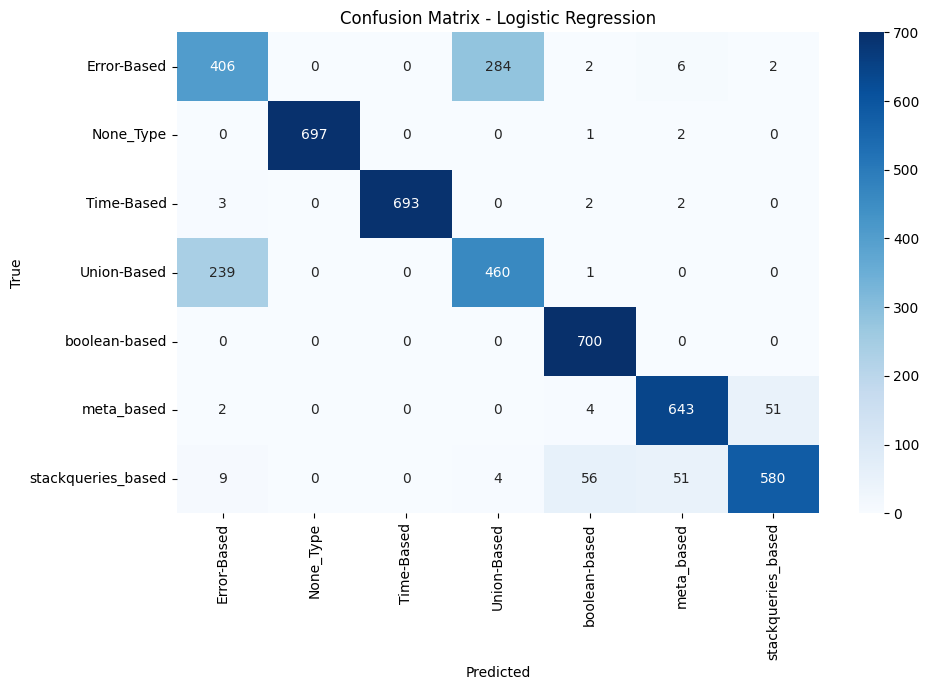


Class: Error-Based
Top positive indicators:
  where: 6.0569
  name: 5.3251
  having: 5.1162
  by: 4.4142
  order: 4.4142
  version: 2.6988
  substring: 2.4049
  8310: 2.3916
  pyty: 2.2013
  pytw: 2.1503
  7423: 2.0375
  7300: 1.9653
  injectx: 1.8648
  as: 1.8648
  5913: 1.6964
  1427: 1.4812
  1083: 1.4812
  pklz: 1.3226
  16: 1.2348
  11: 1.2332
Top negative indicators:
  or: -7.2150
  test: -5.2626
  username: -5.1500
  sleep: -4.9849
  null: -3.5548
  and: -3.1453
  not: -2.1943
  length: -2.1443
  pg_sleep: -1.9690
  union: -1.9289
  count: -1.7877
  active: -1.7868
  email: -1.7480
  randomblob: -1.7474
  68: -1.7249
  ascii: -1.7014
  like: -1.6886
  exec: -1.6169
  benchmark: -1.5590
  delay: -1.5530

Class: None_Type
Top positive indicators:
  shipped: 5.9420
  pending: 5.9239
  safe: 5.8308
  active: 5.4654
  email: 4.6556
  01: 4.2262
  null: 4.0786
  example: 3.4424
  com: 3.4424
  order_id: 3.3144
  price: 3.2135
  in: 3.1223
  created_at: 3.0697
  like: 3.0288
  between

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
TRAIN_PER_CLASS = 7300
VAL_PER_CLASS = 2000
TEST_PER_CLASS = 700
TOTAL_PER_CLASS = TRAIN_PER_CLASS + VAL_PER_CLASS + TEST_PER_CLASS  # 10000

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
data = pd.read_csv('/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv').drop_duplicates()

# Define the label column
data['Combined Label'] = data['injection_type']

# Balance to TOTAL_PER_CLASS per class (oversample with replacement if needed)
balanced_parts = []
for label in data['Combined Label'].unique():
    class_data = data[data['Combined Label'] == label]
    n = len(class_data)
    if n == 0:
        print(f"Skipping class {label} (0 samples).")
        continue
    if n >= TOTAL_PER_CLASS:
        sampled = class_data.sample(n=TOTAL_PER_CLASS, random_state=SEED, replace=False)
    else:
        sampled = class_data.sample(n=TOTAL_PER_CLASS, random_state=SEED, replace=True)
    balanced_parts.append(sampled)

if not balanced_parts:
    raise RuntimeError("No classes available after balancing. Check your dataset.")

balanced_data = pd.concat(balanced_parts, axis=0).reset_index(drop=True)

# Create a deterministic label mapping (sorted for stability)
unique_labels = sorted(balanced_data['Combined Label'].unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
inv_label_mapping = {v: k for k, v in label_mapping.items()}
balanced_data['label'] = balanced_data['Combined Label'].map(label_mapping)

# -------------------------------
# Exact Per-Class Split: 7300 / 2000 / 700
# -------------------------------
train_list, val_list, test_list = [], [], []

for label in unique_labels:
    class_df = balanced_data[balanced_data['Combined Label'] == label].sample(frac=1.0, random_state=SEED)  # shuffle within class
    # Exact slicing since each class has TOTAL_PER_CLASS rows now
    train_part = class_df.iloc[:TRAIN_PER_CLASS]
    val_part = class_df.iloc[TRAIN_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS]
    test_part = class_df.iloc[TRAIN_PER_CLASS + VAL_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS + TEST_PER_CLASS]

    # Safety checks
    assert len(train_part) == TRAIN_PER_CLASS, f"Train size mismatch for class {label}"
    assert len(val_part) == VAL_PER_CLASS, f"Val size mismatch for class {label}"
    assert len(test_part) == TEST_PER_CLASS, f"Test size mismatch for class {label}"

    train_list.append(train_part)
    val_list.append(val_part)
    test_list.append(test_part)

train_df = pd.concat(train_list, axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)  # shuffle final train
val_df = pd.concat(val_list, axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)      # shuffle final val
test_df = pd.concat(test_list, axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)    # shuffle final test

print("Per-split class counts:")
print("Train:\n", train_df['Combined Label'].value_counts().sort_index())
print("Val:\n", val_df['Combined Label'].value_counts().sort_index())
print("Test:\n", test_df['Combined Label'].value_counts().sort_index())

print(f"Training size: {len(train_df)}, Validation size: {len(val_df)}, Testing size: {len(test_df)}")

# -------------------------------
# TF-IDF (fit on train only to avoid leakage)
# -------------------------------
tfidf = TfidfVectorizer(max_features=5000)

X_train = tfidf.fit_transform(train_df['sql_query'])
y_train = train_df['label'].to_numpy()

X_val = tfidf.transform(val_df['sql_query'])
y_val = val_df['label'].to_numpy()

X_test = tfidf.transform(test_df['sql_query'])
y_test = test_df['label'].to_numpy()

# -------------------------------
# Logistic Regression Model (Linear classifier)
# -------------------------------
logreg_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='saga',
    multi_class='multinomial',
    max_iter=200,
    verbose=1,
    random_state=SEED
    # If your sklearn version supports it for saga, you can add: n_jobs=-1
)

print("Training Logistic Regression...")
logreg_model.fit(X_train, y_train)
print("Training complete.")

# -------------------------------
# Evaluation
# -------------------------------
predictions = logreg_model.predict(X_test)
predicted_probs = logreg_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

n_classes = len(unique_labels)
if n_classes > 2:
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    auc_roc = roc_auc_score(y_test_bin, predicted_probs, multi_class="ovr")
    mAP = average_precision_score(y_test_bin, predicted_probs, average="macro")
else:
    auc_roc = roc_auc_score(y_test, predicted_probs[:, 1])
    mAP = average_precision_score(y_test, predicted_probs[:, 1])

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")

target_names = [inv_label_mapping[i] for i in range(n_classes)]
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=target_names))

cm = confusion_matrix(y_test, predictions, labels=list(range(n_classes)))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

# -------------------------------
# Feature Importance (Top Coefficients)
# -------------------------------
feature_names = tfidf.get_feature_names_out()
coefs = logreg_model.coef_

top_k = 20  # number of top terms per class
for class_idx, class_name in enumerate(target_names):
    class_coefs = coefs[class_idx]
    top_pos_idx = np.argsort(class_coefs)[-top_k:][::-1]
    top_neg_idx = np.argsort(class_coefs)[:top_k]
    print(f"\nClass: {class_name}")
    print("Top positive indicators:")
    for i in top_pos_idx:
        print(f"  {feature_names[i]}: {class_coefs[i]:.4f}")
    print("Top negative indicators:")
    for i in top_neg_idx:
        print(f"  {feature_names[i]}: {class_coefs[i]:.4f}")